# Exploratory Data Analysis - NYC Taxi Trip Duration

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
sns.set_theme()
sns.set_style('whitegrid')

In [3]:
# load data
train_data = pd.read_csv('data/W22P1_train.csv', index_col=0)
test_data = pd.read_csv('data/W22P1_test.csv', index_col=0)

# add log of trip_duration as variable (we see why later)
train_data['log_trip_duration'] = np.log10(train_data['trip_duration'])

# convert pickup_date and pickup_time to pickup_datetime
train_data.insert(0, 'pickup_datetime', train_data.pickup_date + ' ' + train_data.pickup_time)
train_data['pickup_datetime'] = pd.to_datetime(train_data['pickup_datetime'])

train_data.drop(columns=['pickup_date', 'pickup_time'], inplace=True)

# list of names of covariates
covariates = list(train_data.columns[:-2])


# sample points for plots since full dataset is too large for purposes of producing plots
sample_size = 500
sample_train_data = train_data.sample(sample_size)

train_data.head()

,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,log_trip_duration
id,,,,,,,,
0,2016-01-07 19:32:15,1,-73.986389,40.756615,-73.999794,40.761631,520,2.716003
1,2016-01-27 08:07:32,1,-73.956039,40.767609,-73.968201,40.786690,989,2.995196
2,2016-01-31 13:52:55,1,-73.975998,40.751137,-74.001854,40.735229,657,2.817565
3,2016-01-19 08:00:19,3,-73.960121,40.781952,-73.971970,40.755039,1035,3.014940
4,2016-01-25 23:32:14,1,-73.987434,40.760139,-73.990982,40.744862,621,2.793092


## Distribution of `trip_duration` (Target Variable)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


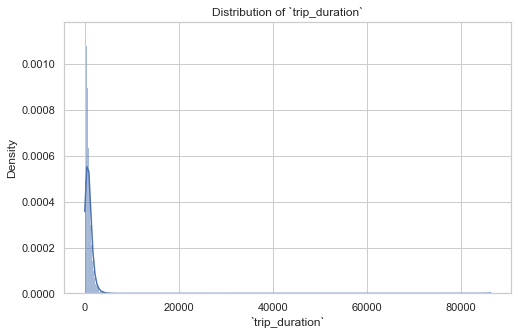

In [4]:
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(data=train_data, x='trip_duration', kde=True, stat='density', element='bars', ax=ax);
ax.set_title('Distribution of `trip_duration`');
ax.set_xlabel('`trip_duration`');

fig.savefig('figs/trip_duration_dist.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


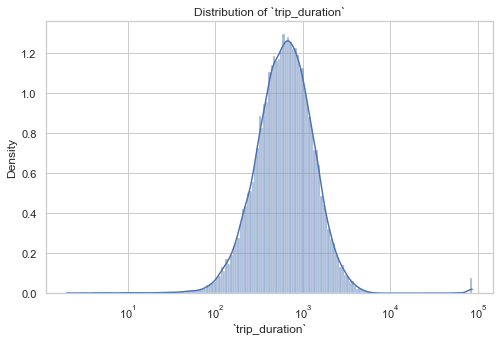

In [5]:
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(data=train_data, x='trip_duration', kde=True, log_scale=True, stat='density', element='bars', ax=ax);
ax.set_title('Distribution of `trip_duration`');
ax.set_xlabel('`trip_duration`');

fig.savefig('figs/trip_duration_log_dist.eps')

The logarithm of the trip durations looks to have a roughly normal distribution. Let's test this.

In [6]:
import scipy.stats
_, p = scipy.stats.normaltest(np.log10(train_data['trip_duration'].sample(1000).to_numpy()))
print('Normality test p-value: ', p)

Normality test p-value:  4.409606941448971e-19


## Relationship Between Covariates

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


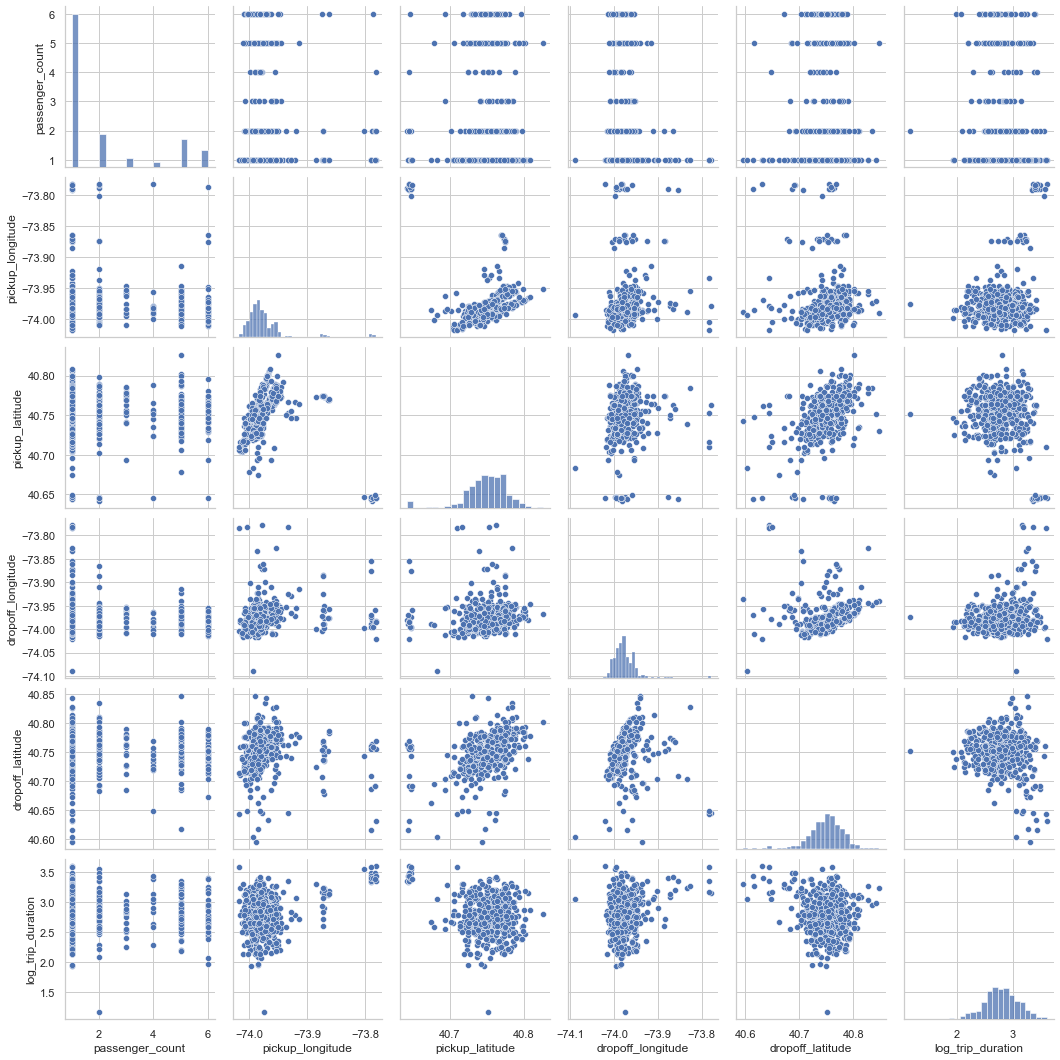

In [7]:
grid = sns.pairplot(data=sample_train_data[covariates+['log_trip_duration']]);
grid.savefig('figs/pairplot.eps')

## `trip_duration` as a function of pickup location

In [8]:
fig = px.scatter_mapbox(train_data.sample(1500), lat="pickup_latitude", lon="pickup_longitude", color="log_trip_duration",
                  opacity=0.65, color_continuous_scale='dense', zoom=11,
                  mapbox_style="carto-positron", width=800, height=800,
                  title="Effect of Pickup Location on Trip Duration")
fig.show()
fig.write_image('figs/pickup_trip_dur.svg')
fig.write_image('figs/pickup_trip_dur.png')

## `trip_duration` as a function of dropoff location

In [9]:
fig = px.scatter_mapbox(train_data.sample(1500), lat="dropoff_latitude", lon="dropoff_longitude", color="log_trip_duration",
                  opacity=0.65, color_continuous_scale='dense', zoom=11,
                  mapbox_style="carto-positron", width=800, height=800,
                  title="Effect of Pickup Location on Trip Duration")
fig.show()
fig.write_image('figs/dropoff_trip_dur.svg')
fig.write_image('figs/dropoff_trip_dur.png')

## Exploring Distance

**Hypothesis:** trip duration is correlated with the distance between the dropoff locations.

The pickup and dropoff locations are given in lattitude-logitude coordiantes, so we will need to use the Haversine distance.

In [10]:
from math import sin, cos, sqrt, atan2, radians

def calc_haversine_distance(lat1, lon1, lat2, lon2):
    '''
    Calculate the distance between two points in lattitude-longitude coordinates.

    Uses Haversine distance.
    '''
    #  radius of earth in km
    R = 6373.0

    # lattitude-longitude are given in degrees. convert to radians
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2

    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

In [11]:
distances = [calc_haversine_distance(x.pickup_latitude, x.pickup_longitude, x.dropoff_latitude, x.dropoff_longitude) 
                for x in train_data.itertuples()]
train_data['distance_km'] = distances

In [12]:
sum(train_data['distance_km']==0)

154

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


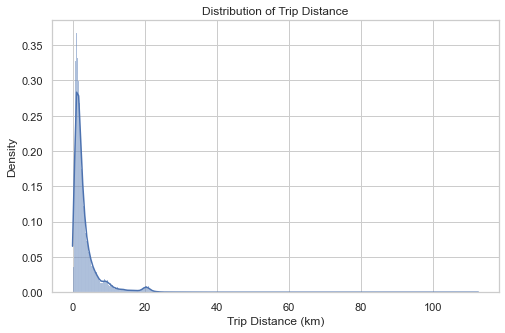

In [13]:
# distribution of distances
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(data=train_data, x='distance_km', kde=True, stat='density', element='bars', ax=ax);
ax.set_title('Distribution of Trip Distance');
ax.set_xlabel('Trip Distance (km)');

fig.savefig('figs/distance_km_dist.eps')

Weirdly, some trips have distance 0...

In [14]:
print(f'# of 0-distance trips: {sum(train_data.distance_km==0)} out of {len(train_data)}')

# of 0-distance trips: 154 out of 30000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


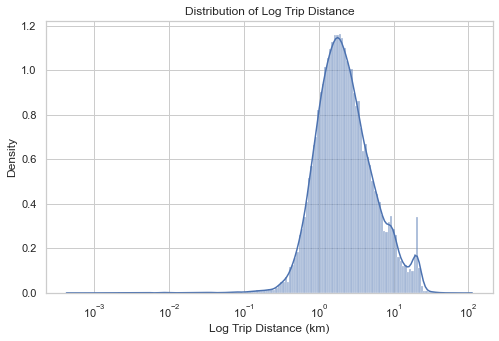

In [15]:
# distribution of log of distances
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(data=train_data[train_data.distance_km>0], x='distance_km', log_scale=True, kde=True, stat='density', element='bars', ax=ax);
ax.set_title('Distribution of Log Trip Distance');
ax.set_xlabel('Log Trip Distance (km)');

fig.savefig('figs/log_distance_km_dist.eps')

Now, let's explore the relationship between trip distance and trip duration...

C:\Users\awnya\AppData\Local\Temp\ipykernel_32472\611485157.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


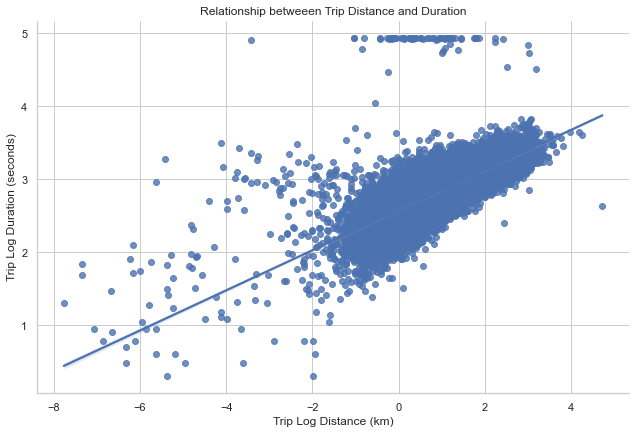

In [16]:
# Relationship between trip distance and duration

mask = train_data['distance_km'] != 0
train_data_ = train_data[mask]
train_data_['log_distance_km'] = np.log(train_data_['distance_km'])

distdurplot = sns.lmplot(x="log_distance_km", y="log_trip_duration", data=train_data_, height=6, aspect=1.5)

distdurplot.ax.set_title('Relationship betweeen Trip Distance and Duration');
distdurplot.ax.set_xlabel('Trip Log Distance (km)');
distdurplot.ax.set_ylabel('Trip Log Duration (seconds)');

distdurplot.savefig('figs/log_distance_duration_lm.eps')

Seems mostly follows a linear relationship, but there is a clump of outliers with short trips but long trip durations...

## L1 (Manhattan) Distance
Taxi's aren't taking a direct path to their destination, they're following the NYC grid. Thus, we might expect the L1 distance to be more strongly correlated with the trip duration than euclidean distance.

In [17]:
def manhattan_dist(lat1, lon1, lat2, lon2):
    # code based on https://medium.com/@simplyjk/why-manhattan-distance-formula-doesnt-apply-to-manhattan-7db0ebb1c5f6
    # by Jayakrishnan (JK) Vijayaraghavan

    # Pickup coordinates
    p = np.expand_dims(np.array([lat1, lon1]), axis=0)

    # Dropoff coordinates
    d = np.expand_dims(np.array([lat2, lon2]), axis=0)

    # inclination of manhattan w.r.t. geographic north
    theta1 = np.radians(-28.904)
    theta2 = np.radians(28.904)

    ## Rotation matrix
    R1 = np.array([[np.cos(theta1), np.sin(theta1)],
                    [-np.sin(theta1), np.cos(theta1)]]
                    )
    R2 = np.array([[np.cos(theta2), np.sin(theta2)],
                    [-np.sin(theta2), np.cos(theta2)]]
                    )

    # Rotate Pickup and Dropoff coordinates by -29 degress in World2
    pT = R1 @ p.T
    dT = R1 @ d.T

    # Coordinates of Hinge point in the rotated world
    vT = np.stack((pT[0,:], dT[1,:]))

    # Coordinates of Hinge point in the real world
    v = R2 @ vT

    ax1_dist = calc_haversine_distance(p.T[0], p.T[1], v[0], v[1])
    ax2_dist = calc_haversine_distance(v[0], v[1], d.T[0], d.T[1])

    manhattan_dist = ax1_dist + ax2_dist

    return manhattan_dist

In [18]:
manhattan_distances = [manhattan_dist(x.pickup_latitude, x.pickup_longitude, x.dropoff_latitude, x.dropoff_longitude)
                for x in train_data.itertuples()]
train_data['l1_distance_km'] = manhattan_distances

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


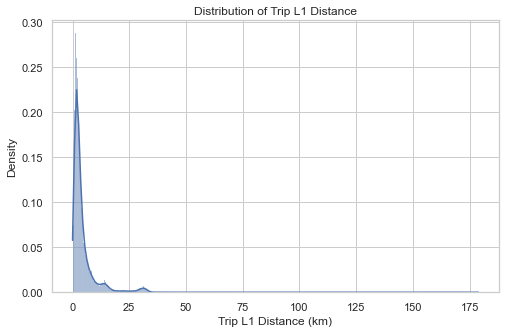

In [19]:
# distribution of L1 distances
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(data=train_data, x='l1_distance_km', kde=True, stat='density', element='bars', ax=ax);
ax.set_title('Distribution of Trip L1 Distance');
ax.set_xlabel('Trip L1 Distance (km)');

fig.savefig('figs/l1_distance_km_dist.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


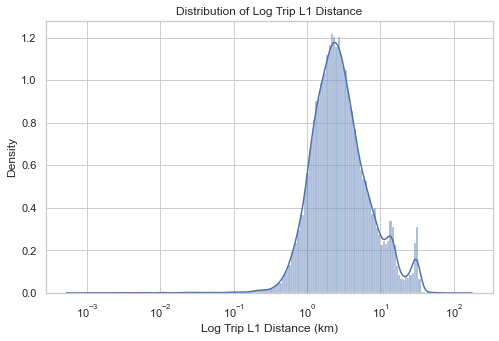

In [20]:
# distribution of log of L1 distances
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(data=train_data[train_data.distance_km>0], x='l1_distance_km', log_scale=True, kde=True, stat='density', element='bars', ax=ax);
ax.set_title('Distribution of Log Trip L1 Distance');
ax.set_xlabel('Log Trip L1 Distance (km)');

fig.savefig('figs/log_l1_distance_km_dist.eps')

C:\Users\awnya\AppData\Local\Temp\ipykernel_32472\1948001931.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


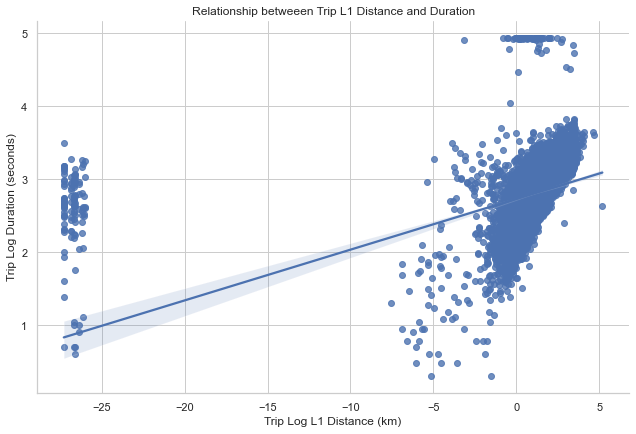

In [21]:
# Relationship between trip distance and duration

mask = train_data['l1_distance_km'] != 0
train_data_ = train_data[mask]
train_data_['log_l1_distance_km'] = np.log(train_data_['l1_distance_km'])

distdurplot = sns.lmplot(x="log_l1_distance_km", y="log_trip_duration", data=train_data_, height=6, aspect=1.5)
distdurplot.ax.set_title('Relationship betweeen Trip L1 Distance and Duration');
distdurplot.ax.set_xlabel('Trip Log L1 Distance (km)');
distdurplot.ax.set_ylabel('Trip Log Duration (seconds)');

distdurplot.savefig('figs/log_l1_distance_duration_lm.eps')

## Making use of the month (seasonality)

In [22]:
print(f'First day: {min(train_data.pickup_datetime).date()}; Last day: {max(train_data.pickup_datetime).date()}')

First day: 2016-01-01; Last day: 2016-01-31


Actually, it turns out this data is all from January 2016. Perhaps we can look into using the day in the date, but I don't know how I feel about that. Seems like a recipe for overfitting. Day-of-week is a good feature to use though.

## Making use of the day-of-week

In [23]:
train_data.insert(1, 'dayofweek', train_data['pickup_datetime'].apply(lambda x: x.day_name()))
train_data['dayofweek'].value_counts()

Friday       5397
Saturday     4566
Sunday       4437
Thursday     4171
Wednesday    4068
Tuesday      3809
Monday       3552
Name: dayofweek, dtype: int64

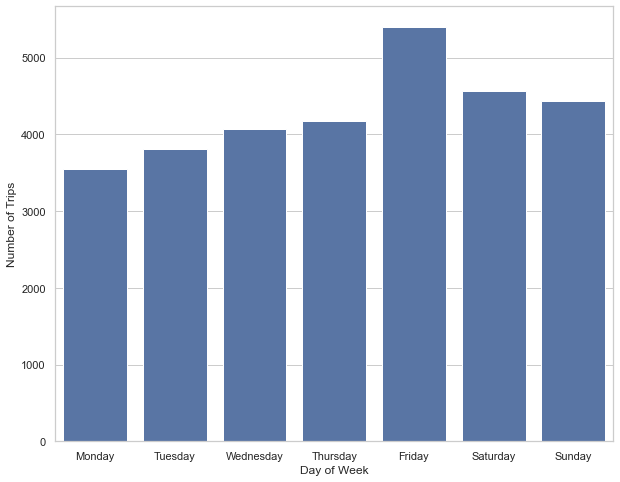

In [24]:
num_trips_day = train_data['dayofweek'].value_counts()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x=num_trips_day.index, y=num_trips_day, order=days, ax=ax, color='b')
ax.set_xlabel('Day of Week');
ax.set_ylabel('Number of Trips');
# ax.set_title('Relationship between Hour-of-Day and Trip Duration');

fig.savefig('figs/num_trips_day.eps')

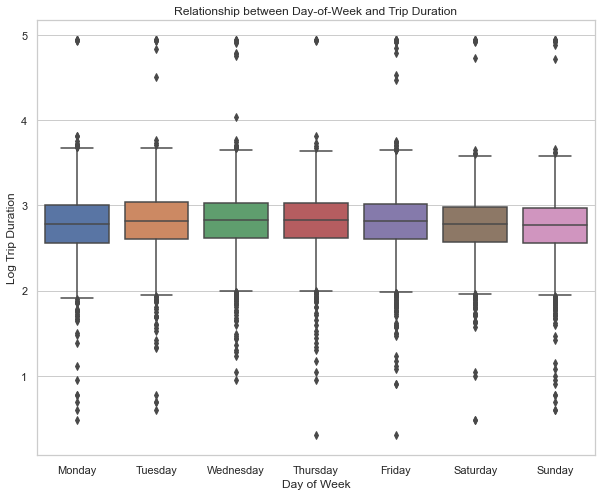

In [25]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(x='dayofweek', y='log_trip_duration', data=train_data, order=days, ax=ax);
ax.set_xlabel('Day of Week');
ax.set_ylabel('Log Trip Duration');
ax.set_title('Relationship between Day-of-Week and Trip Duration');

fig.savefig('figs/dayofweek_trip_dur.eps')

## Time-of-Day

In [26]:
train_data.insert(2, 'hour', train_data['pickup_datetime'].apply(lambda x: x.hour))

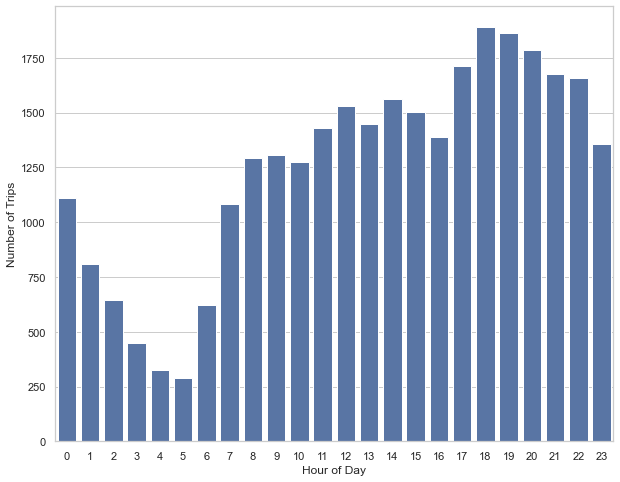

In [27]:
num_trips_hours = train_data['hour'].value_counts().sort_index()
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x=num_trips_hours.index, y=num_trips_hours, ax=ax, color='b')
ax.set_xlabel('Hour of Day');
ax.set_ylabel('Number of Trips');
# ax.set_title('Relationship between Hour-of-Day and Trip Duration');

fig.savefig('figs/num_trips_hr.eps')

As expected, there are more trips at active times of day. Perhaps traffic has an effect on trip durations?

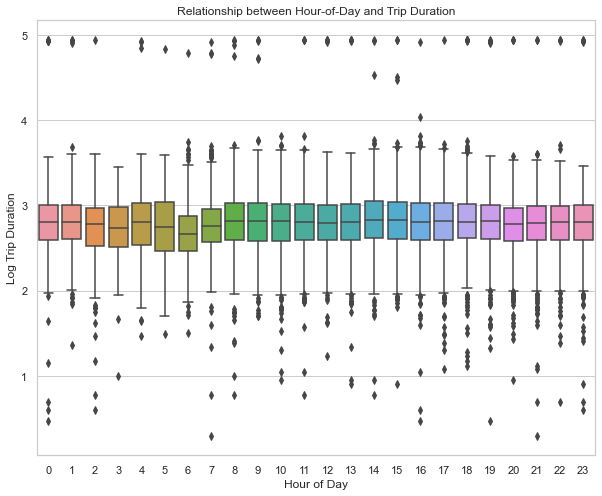

In [28]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=train_data, x="hour", y="log_trip_duration", ax=ax)
ax.set_xlabel('Hour of Day');
ax.set_ylabel('Log Trip Duration');
ax.set_title('Relationship between Hour-of-Day and Trip Duration');

fig.savefig('figs/hour_trip_dur.eps')